In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
90000/12

7500.0

### Загрузим уже обработанные в прошлом ДЗ данные!

In [3]:
df = pd.read_csv('processed_sigma.csv')
df = df.drop("Trip_ID", axis=1)

X = df.drop("Surge_Pricing_Type", axis=1)
y = df["Surge_Pricing_Type"]

### Principal component analysis (PCA)

**Задание 1.** Спроецируйте данные на двумерную плоскость, используя `PCA`. Другими словами, выделите первые две главные компоненты и изобразите данные в осях этих компонент. Не забудьте центрировать признаки перед применением метода. 

**Какую долю изначальной дисперсии (информации) содержат/объясняют в себе обе компоненты?** Для этого воспользуйтесь атрибутом `explained_variance_ratio_` у PCA-класса.

In [4]:
### Центрируем данные

X_centered = X - X.mean()

In [5]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)

pca.fit(X)

pca_df = pd.DataFrame(pca.transform(X), columns=['PCA1', 'PCA2'])

In [8]:
pca_df.head()

,PCA1,PCA2
0,-38.743132,-23.282634
1,-13.209252,-25.023815
2,-2.004910,-1.637085
3,17.178458,-0.907657
4,14.477389,-11.656752


In [9]:
pca.explained_variance_ratio_

array([0.63176117, 0.21129863])

In [43]:
pca.n_components

2

**Задание 2.** Изобразите heatmap корреляции изначальных признаков с новыми двумя главными компонентами. \
**Какие признаки коррелируют с первой компонентой? Какие со второй? В качестве порогового значения договоримся о корреляции >= 0.5 по абсолютному значению **


In [9]:
import seaborn as sns

In [10]:
pca1_corr = X.corrwith(pca_df['PCA1'])
pca2_corr = X.corrwith(pca_df['PCA2'])

corrs = pd.concat((pca1_corr, pca2_corr), axis=1)
corrs.columns = ['PCA_1', 'PCA_2']

In [11]:
corrs.head(2)

,PCA_1,PCA_2
Trip_Distance,0.997767,0.01841
Customer_Since_Months,0.121591,0.00350


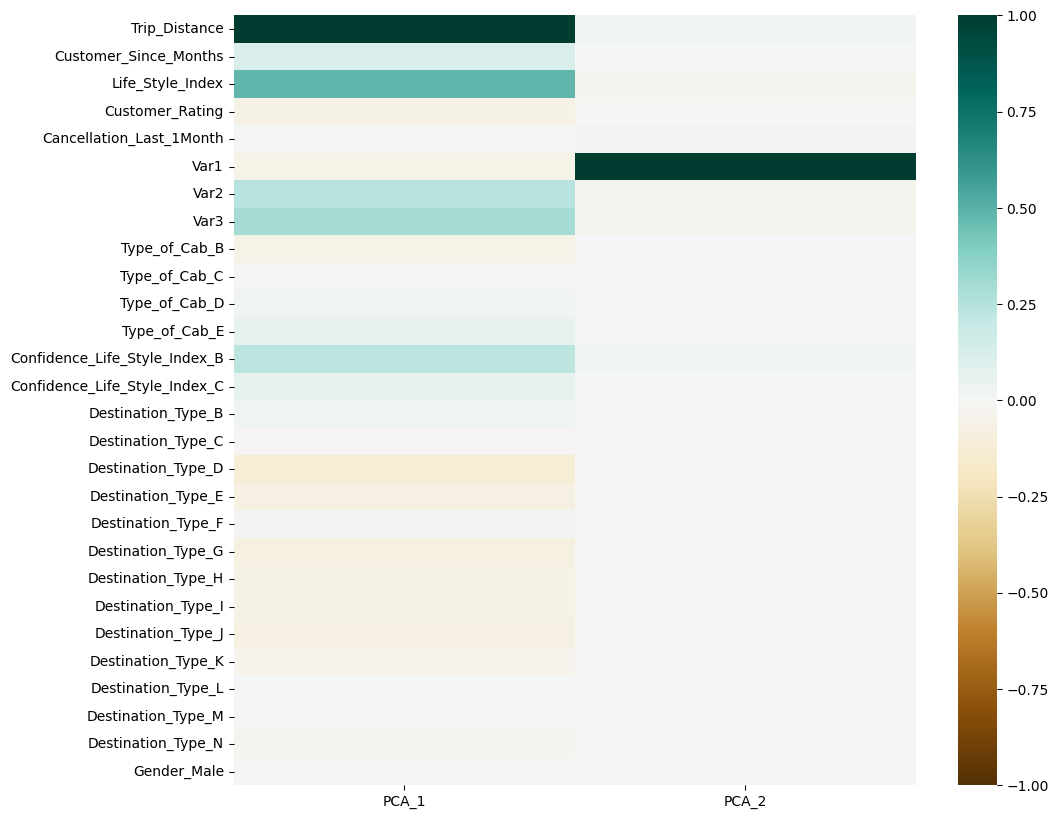

In [12]:
fig = plt.figure()

fig.set_size_inches(11, 10)

sns.heatmap(corrs,
           xticklabels = corrs.columns,
           yticklabels = corrs.index,
           cmap = 'BrBG',
           vmin = -1,
           vmax = 1)

plt.show()

**Задание 3.** Изобразите двумерную проекцию данных с метками классов. Выделите третью главную компоненту и аналогично нарисуйте трехмерную проекцию с метками классов. \
**Какие признаки коррелируют с третьей компонентой?**

In [13]:
pca_df = np.concatenate((pca_df.values, y.values.reshape(-1, 1)), axis=1)
pca_df = pd.DataFrame(pca_df, columns=['PCA_1', 'PCA_2', 'segment'])
pca_df.head(3)


,PCA_1,PCA_2,segment
0,-38.743132,-23.282634,2.0
1,-13.209252,-25.023815,2.0
2,-2.004910,-1.637085,2.0


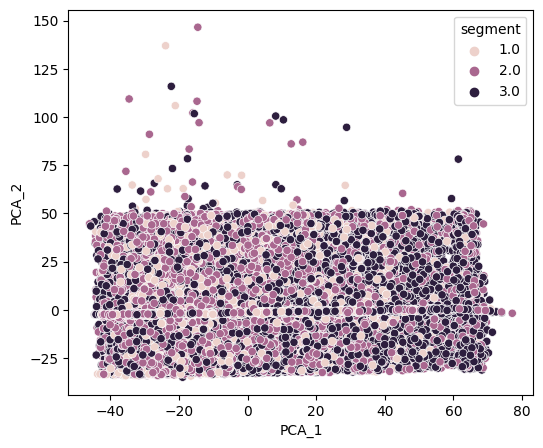

In [14]:
fig = plt.figure()
fig.set_size_inches(6,5)

sns.scatterplot(data=pca_df, x='PCA_1', y='PCA_2', hue='segment')

plt.show()

In [17]:
pca3 = PCA(n_components=3)

pca3.fit(X)

pca3_df = pd.DataFrame(pca3.transform(X), columns=['PCA_1', 'PCA_2', 'PCA_3'])

In [19]:
pca3.explained_variance_ratio_

array([0.63176117, 0.21129863, 0.13025786])

In [22]:
corr1 = X.corrwith(pca3_df['PCA_1'])
corr2 = X.corrwith(pca3_df['PCA_2'])
corr3 = X.corrwith(pca3_df['PCA_3'])

corrs_3 = pd.concat((corr1, corr2, corr3), axis=1)

corrs_3.columns = ['PCA_1', 'PCA_2', 'PCA_3']

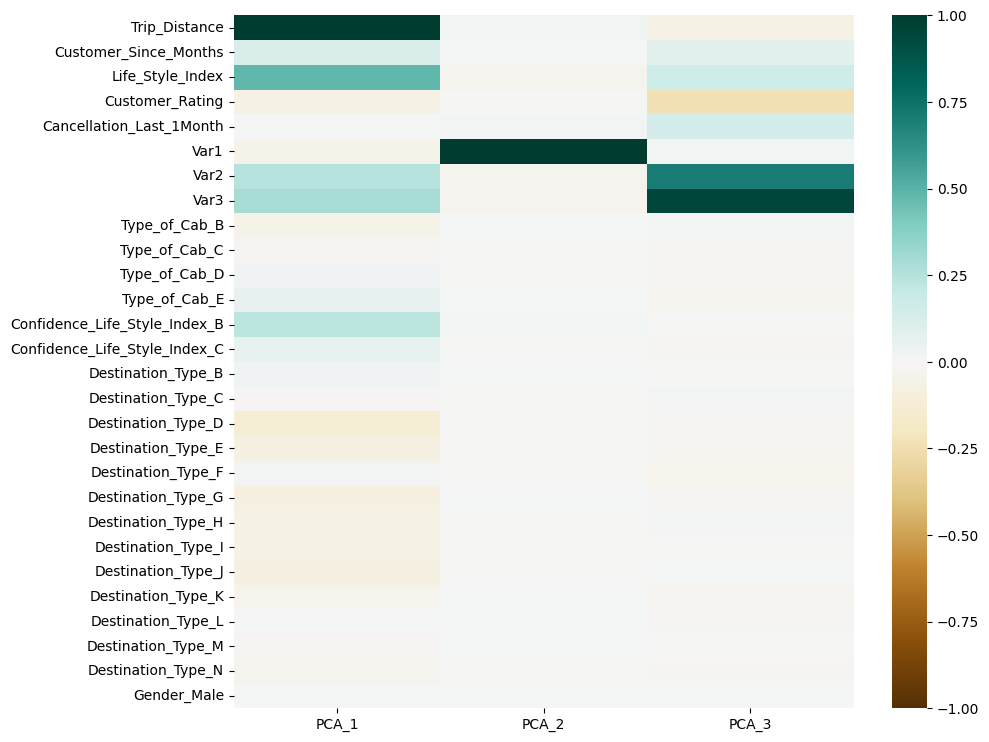

In [23]:
fig = plt.figure()
fig.set_size_inches(10,9)

sns.heatmap(corrs_3,
           xticklabels=corrs_3.columns,
           yticklabels=corrs_3.index,
           cmap='BrBG',
           vmin=-1,
           vmax=1)

plt.show()

Советуем еще и замерить попарные корреляции между главными компонентами! Это поможет в ответе на один из тестовых вопросов.

In [26]:
pca3_df.corr()

,PCA_1,PCA_2,PCA_3
PCA_1,1.000000e+00,-5.731387e-17,4.059849e-17
PCA_2,-5.731387e-17,1.000000e+00,2.355842e-16
PCA_3,4.059849e-17,2.355842e-16,1.000000e+00


**Задание 4.** Обучите логистическую регрессию на первых двух компонентах центрированных данных и подберите гиперпараметры. Обучите логистическую регрессию на центрированных данных и подберите гиперпараметры. **Сравните метрику accuracy и f1-score на тестовой выборке в двух моделях**.

P.S. для удобства, скорости и нормализации данных (понадобится, так как захотим повалидироваться на параметрах регуляризации) можно построить конструкцию Pipeline c 3 следующими степами: StandardScaler -> PCA -> LogisticRegression

In [27]:
np.random.seed(2022)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_centered, y, test_size=0.2, 
                                                    shuffle=True, random_state=2022)

In [30]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)

param_grid = {'model__penalty': ['l1', 'l2', 'elasticnet'],
              'model__C': [1e-5, 0.0001, 0.001, 0.01]}

grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy')

grid_search.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [1e-05, 0.0001, 0.001, 0.01],
                         'model__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [32]:
grid_search.best_score_

0.48057042024220153

In [37]:
print(classification_report(y_test, grid_search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.000     0.000     0.000      5372
           2      0.479     0.699     0.568     11349
           3      0.496     0.504     0.500      9612

    accuracy                          0.485     26333
   macro avg      0.325     0.401     0.356     26333
weighted avg      0.387     0.485     0.427     26333



In [33]:
pipe_origin = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# pipe_origin.fit(X_train, y_train)

param_grid = {'model__penalty': ['l1', 'l2', 'elasticnet'],
              'model__C': [1e-5, 0.0001, 0.001, 0.01]}

grid_search_origin = GridSearchCV(pipe_origin, param_grid=param_grid, scoring='accuracy')

grid_search_origin.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [1e-05, 0.0001, 0.001, 0.01],
                         'model__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [34]:
grid_search_origin.best_score_

0.6803919317784358

In [40]:
print(classification_report(y_test, grid_search_origin.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.746     0.532     0.621      5372
           2      0.636     0.830     0.720     11349
           3      0.736     0.589     0.655      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.665     26333
weighted avg      0.695     0.681     0.676     26333



Кажется, достаточно сильно теряем в качестве! Может, добавить компонент?

**Задание 5.** Обучите модели логистической регресии на нескольких различных компонентах: [2, 4, 8, 16, 28]. **Нарисуйте графики зависимости accuracy, f1-score от количества компонент. Введите их значения через запятую**. При обучении используйте l2-регуляризацию, гиперпараметр C подбирайте по сетке. 


In [44]:
### Чтобы не заставлять вас писать похожий на предыдущий код,
### Написали функцию, которая будет обучать модель для
### произвольного числа n_components главных компонент.

def train_pca_i(n_components, X_train, y_train):
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=n_components)),
                     ('model', LogisticRegression(penalty='l2', solver='saga',random_state=1))])
    
    param_grid = {'model__C': [0.0001, 0.001, 0.01, 0.1]}
    
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    report = classification_report(y_test, grid.predict(X_test), output_dict=True)
    return (report['accuracy'], 
            report['weighted avg']['f1-score'])

In [51]:
%%time
accuracy_dict, f1_score_dict = {}, {}
components_list = [2, 4, 8, 16, 28]

for n_components in components_list:
    result = train_pca_i(n_components, X_train, y_train)
    accuracy_dict[n_components] = result[0]
    f1_score_dict[n_components] = result[1]
    

CPU times: user 3min 38s, sys: 1min 4s, total: 4min 43s
Wall time: 1min 45s


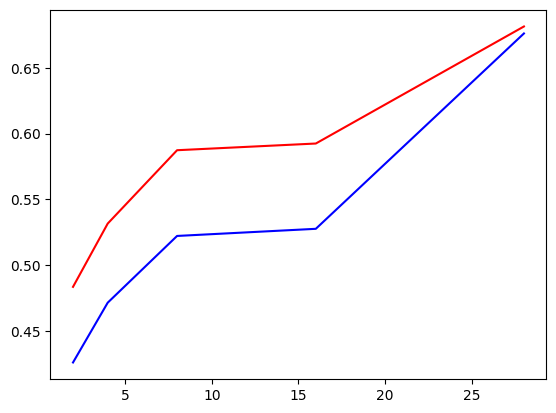

In [52]:
fig = plt.figure()

plt.plot(accuracy_dict.keys(), accuracy_dict.values(), color='red')
plt.plot(f1_score_dict.keys(), f1_score_dict.values(), color='blue')


plt.show()

Обычно, когда решается какая-то высокоразмерная предсказательная задача, где тысячи признаков, функция качества PCA моделей похожа на параболу ветвями вниз в зависимости от количества компонент (для совсем маленьких и больших n_component качество маленькое, при этом есть где-то промежуточное значение).

Как думаете, почему здесь у нас непрерывно растущие графики качества?

Может, изначальные признаки были слишком хороши?

### t-SNE

Напомним, что метод заключается в введении некоторых функций, основанных на расстоянии между признаками, которые измеряют близость объектов. Функций, как вы помните, две, и они заданы в исходном и новом пространствах соотвественно. Далее минимизируем дивергенцию Кульбака-Лейблера по координатaм в новом пространстве

**Задание 6.** Обучите t-sne c `n_components=2` на изначальных данных и визуализируйте результаты с учетом известных классов. 

P.S. если устанете ждать обучения TSNE, или упадет ошибка по типу oom, то можно сократить число объектов в датасете до, например, пары тысяч. Это и следующее задания никак проверяться системой не будут. Вам достаточно повторить упражнение с практики и получить какое-то более адекватное (по сравнению с PCA) изображение классов.

In [54]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)

X_tsne


array([[42.236168 ,  7.4941263],
       [28.782415 , 22.998125 ],
       [ 8.633523 , 20.641209 ],
       ...,
       [11.394857 ,  5.3817964],
       [14.850629 , 30.819983 ],
       [29.048199 , -4.7246146]], dtype=float32)

In [58]:
X_tsne = np.concatenate((X_tsne, y.values.reshape(-1,1)), axis=1)

X_tsne = pd.DataFrame(X_tsne, columns=['Tsne_1comp', 'Tsne_2comp', 'segment'])

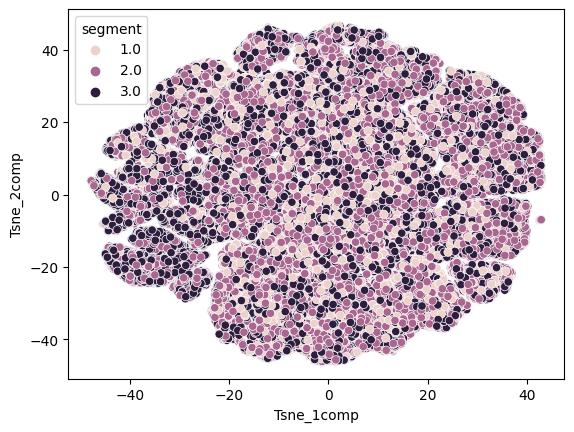

In [59]:
fig = plt.figure()

sns.scatterplot(X_tsne, x='Tsne_1comp', y='Tsne_2comp', hue='segment')

plt.show()

**Задание 7.** Обучите t-sne с `n_components=3` на изначальных данных и визуализируйте результаты с учетом известных классов.

In [60]:
X_tsne3 = TSNE(n_components=3).fit_transform(X)


In [61]:
X_tsne3 = np.concatenate((X_tsne3, y.values.reshape(-1,1)), axis=1)

X_tsne3 = pd.DataFrame(X_tsne3, columns=['Tsne_1comp', 'Tsne_2comp', 'Tsne_3comp', 'segment'])

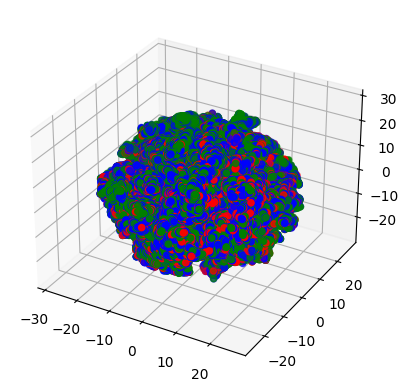

In [64]:
fig = plt.figure()

ax = plt.axes(projection='3d')

colors = X_tsne3['segment'].replace([1, 2, 3], ['red', 'blue', 'green'])

ax.scatter(X_tsne3['Tsne_1comp'],
           X_tsne3['Tsne_2comp'],
           X_tsne3['Tsne_3comp'],
           c=colors)

plt.show()

Советуем обрезать датасет до маленького числа объектов (чтобы точки и их группки были хорошо различимы) и поиграться с гиперпараметрами класса Tsne! Обычно такая "игра" может привести к куда более красивым результатам по сравнению с теми, что получены с дефолтными настройками!